In [28]:
! pip install -q qiskit
! pip install -q qiskit-aer
! pip install -q qiskit-algorithms
! pip install -q qiskit-nature
! pip install -q qiskit-nature-pyscf # install the pyscf library
! pip install -q qiskit-ibm-runtime
# print(qiskit.__version__)
# print(qiskit_aer.__version__)
# print(qiskit_algorithms.__version__)
# print(qiskit_nature.__version__)
# print(qiskit_nature_pyscf.__version__)
# print(qiskit_ibm_runtime.__version__)

In [29]:
import qiskit_nature
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime
import qiskit_nature_pyscf
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer import  AerSimulator
# from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from scipy.linalg import eigh
from qiskit_nature.second_q.circuit.library import HartreeFock
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from numpy import pi

# Analysis of Li atom in 10 spin orbitals:

In [30]:
mdriver = PySCFDriver(
    atom="Li 0.0 0.0 0.0",  # Specify the atom and its coordinates
    basis="sto3g",          # Define the basis set
    charge=0,                # Set the charge of the atom
    spin=1,                 # Set the spin of the atom
    unit=DistanceUnit.ANGSTROM, # Define the unit of the coordinates
)

# You can now use the driver to run a calculation
electronic_structure_problem = mdriver.run()

In [31]:
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print("\n")
print("Down spin configuration : ", electronic_structure_problem.orbital_occupations_b)
print("Down spin configuration : ",electronic_structure_problem.orbital_occupations)
print("Number of particles: ", electronic_structure_problem.num_particles)
# print(electronic_structure_problem.second_q_ops()[0])

Spatial orbitals: 5
Number of up spin:  2
Number of down spin:  1


Down spin configuration :  [1. 0. 0. 0. 0.]
Down spin configuration :  [1. 1. 0. 0. 0.]
Number of particles:  (2, 1)


In [32]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

result = solver.solve(electronic_structure_problem)
print(result)
print("HF energy : ", electronic_structure_problem.reference_energy)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.315836552851
  - computed part:      -7.315836552851
~ Nuclear repulsion energy (Hartree): 0.0
> Total ground state energy (Hartree): -7.315836552851
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: -0.430
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
HF energy :  -7.315525981281089


In [33]:
mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(electronic_structure_problem.second_q_ops()[0])
state = HartreeFock(electronic_structure_problem.num_spatial_orbitals, electronic_structure_problem.num_particles, mapper)
print(state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
q_4: ─────
     ┌───┐
q_5: ┤ X ├
     └───┘
q_6: ─────
          
q_7: ─────
          
q_8: ─────
          
q_9: ─────
          


In [34]:
statevector = Statevector(state)
k = 3
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i in range(k):
    for j in range(k):
        U = expm(-(i-j)*pi*1j*qubit_hamiltonian/0.085354)

        # Apply the unitary operator to the statevector using evolve()
        evolved_statevector = statevector.evolve(U)

        # Now you can access the data of the evolved statevector
        S_sub[i, j] = statevector.expectation_value(U)

        # Now apply hamiltonian to evolved state
        evolved_statevector = evolved_statevector.evolve(qubit_hamiltonian)
        E_sub[i, j] = statevector.inner(evolved_statevector)

print(E_sub)
print(S_sub)


[[-7.31552598+0.j         -4.51441473-5.7554438j   1.74363933-7.10398221j]
 [-4.51441473+5.7554438j  -7.31552598+0.j         -4.51441473-5.7554438j ]
 [ 1.74363933+7.10398221j -4.51441473+5.7554438j  -7.31552598+0.j        ]]
[[ 1.        +0.j          0.61708769+0.78668764j -0.23836513+0.97103201j]
 [ 0.61708769-0.78668764j  1.        +0.j          0.61708769+0.78668764j]
 [-0.23836513-0.97103201j  0.61708769-0.78668764j  1.        +0.j        ]]


In [35]:
def regularize_matrix(matrix, epsilon=1e-10):
    matrix += epsilon * np.eye(matrix.shape[0])
    return matrix
S_sub = regularize_matrix(S_sub)

eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)
# print(eigenvalues[0]- eigenvalues[1])

[-7.31576947 -4.99352327 -4.32763749]
[[-3.45115401e-01+5.32114370e-02j -2.61981857e+01+1.04405128e+01j
  -1.66477647e+02-6.57006918e+01j]
 [-1.91198791e-01+2.43786935e-01j -1.31646761e+01-4.57503650e+01j
   1.34996217e+02+8.74647831e+01j]
 [ 3.05658664e-02+3.47853165e-01j  2.77405668e+01-5.08037331e+00j
  -1.27997931e+02-1.25091636e+02j]]


In [36]:
exact_eva, exact_eve = eigh(qubit_hamiltonian.to_matrix())
print(exact_eva)

[-7.31583655e+00 -7.31583655e+00 -7.25379126e+00 ... -4.90501018e-01
  1.64868119e-14  3.77428002e-01]


In [37]:
eigenvalues

array([-7.31576947, -4.99352327, -4.32763749])

In [38]:
from scipy.linalg import norm
# Here 10 is the number of spin orbitals to used in our calculation

psi_i = Statevector([0] *(2**10))
# print(norm(eigenvectors[0]))
for i in range(k):
    evolved_statevector = statevector.evolve(U)
    psi_i += eigenvectors[0][i] / norm(eigenvectors[0]) * evolved_statevector
print("Unnormalised state:", psi_i.data)
print("Norm of state:", abs(psi_i.inner(psi_i.conjugate())))
print("Ground state energy calculate from state:", psi_i.expectation_value(qubit_hamiltonian)/abs(psi_i.inner(psi_i.conjugate())))

Unnormalised state: [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
Norm of state: 1.2278023809539398
Ground state energy calculate from state: (-7.31552598128106+0j)


In [39]:
psi_norm = abs(psi_i.inner(psi_i.conjugate()))
gs = psi_i/(psi_norm)**0.5
print("Normalised ground state:",gs.data)
print("Ground state energy:",gs.expectation_value(qubit_hamiltonian))
print(abs(gs.inner(gs.conjugate())))

Normalised ground state: [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
Ground state energy: (-7.315525981281075+0j)
1.0000000000000002


In [40]:
gs_state = gs.to_dict()
gs_state

{'0000100011': (-0.9614474320289598-0.27498879148961486j)}

In [41]:
eigenvalues

array([-7.31576947, -4.99352327, -4.32763749])

In [42]:
y = gs_state["0000100011"]
y

(-0.9614474320289598-0.27498879148961486j)

In [43]:
eigenvalues

array([-7.31576947, -4.99352327, -4.32763749])

In [44]:
-7.315836552850645+7.230481653125957

-0.08535489972468824

In [45]:
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print("\n")
print("Down spin configuration : ", electronic_structure_problem.orbital_occupations_b)
print("Down spin configuration : ",electronic_structure_problem.orbital_occupations)
print("Number of particles: ", electronic_structure_problem.num_particles)

Spatial orbitals: 5
Number of up spin:  2
Number of down spin:  1


Down spin configuration :  [1. 0. 0. 0. 0.]
Down spin configuration :  [1. 1. 0. 0. 0.]
Number of particles:  (2, 1)


In [46]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate

qubit_mapper = JordanWignerMapper()
hf_state = HartreeFock(electronic_structure_problem.num_spatial_orbitals, electronic_structure_problem.num_particles, mapper)



evolution_time = 1.0 * 3.1415 /0.085 # Time parameter for the unitary evolution
time_evolution_op = PauliEvolutionGate(qubit_hamiltonian, evolution_time)

qc = QuantumCircuit(10)
qc.compose(hf_state, inplace=True)  # Prepare the HF state
qc.append(time_evolution_op, range(10))  # Apply time evolution
qc.measure_all()


In [103]:
from qiskit.primitives import Sampler
from qiskit.primitives import StatevectorSampler

# Initialize Sampler
sampler = StatevectorSampler()
shots = 100000
# Run the sampler on the quantum circuit
job = sampler.run([qc], shots=shots)
result = job.result()[0]
counts = result.data['meas'].get_counts()
# print("Counts:", counts)
for state, count in counts.items():
    print(f"State |{state}>: {count/shots}")

# from qiskit_aer import Aer
# backend = Aer.get_backend("qasm_simulator")
# from qiskit import transpile
# tqc = transpile(qc, backend)


# shots = 100000
# result = backend.run(tqc, shots=shots).result()
# counts = result.get_counts()

# # Print raw counts
# print("\nMeasurement Counts:")
# for state, count in counts.items():
#     print(f"State |{state}>: {count} occurrences")

State |0010000110>: 0.45752
State |1000010010>: 0.30825
State |0100001010>: 0.12515
State |0100001001>: 0.00822
State |0010000101>: 0.06168
State |1000010001>: 0.03727
State |0001000011>: 0.00182
State |0000100011>: 9e-05


In [106]:

evolution_times = np.linspace(0.0, 20, 20)  # List of time evolution values
evolution_times = 1.0 * 3.1415 /0.085 * evolution_times # Time parameter for the unitary evolution
shots = 100000


mapper = JordanWignerMapper()
hf_state = HartreeFock(
    electronic_structure_problem.num_spatial_orbitals,
    electronic_structure_problem.num_particles,
    mapper
)

# # Step 3: Backend setup
# backend = Aer.get_backend("qasm_simulator")

# Initialize Sampler
sampler = StatevectorSampler()
shots = 100000

# Step 4: Loop over different time evolutions
state_probabilities = {}

for t in evolution_times:
    # Prepare circuit
    qc = QuantumCircuit(hf_state.num_qubits)
    qc.compose(hf_state, inplace=True)  # HF reference state
    evolution_op = PauliEvolutionGate(qubit_hamiltonian, time=t)
    qc.append(evolution_op, range(hf_state.num_qubits))  # Time evolution
    qc.measure_all()

    # # Transpile and simulate
    # tqc = transpile(qc, backend)
    # result = backend.run(tqc, shots=shots).result()
    # counts = result.get_counts()
    job = sampler.run([qc], shots=shots)
    result = job.result()[0]
    counts = result.data['meas'].get_counts()

    # Normalize counts to probabilities
    # total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    print(f"time {t} : ",probabilities)
    # Store probabilities for this time
    state_probabilities[t] = probabilities

# Step 5: Plotting results
# Extract all possible states measured
all_states = set()
for probs in state_probabilities.values():
    all_states.update(probs.keys())

# Sort states for plotting
all_states = sorted(all_states)

time 0.0 :  {'0000100011': 1.0}
time 38.90402476780186 :  {'0010000110': 0.65912, '0100001001': 0.14175, '0000100011': 0.03366, '1000010001': 0.05545, '0010000101': 0.07862, '1000010010': 0.02831, '0100001010': 0.00045, '0001000011': 0.00264}
time 77.80804953560371 :  {'1000010001': 0.15981, '0010000110': 0.24414, '1000010010': 0.19484, '0010000101': 0.09817, '0100001001': 0.23563, '0000100011': 0.00936, '0100001010': 0.0566, '0001000011': 0.00145}
time 116.71207430340559 :  {'0100001010': 0.50729, '1000010010': 0.46866, '0010000110': 0.01545, '1000010001': 0.00262, '0100001001': 0.00523, '0001000011': 0.00015, '0000100011': 0.00058, '0010000101': 2e-05}
time 155.61609907120743 :  {'0100001010': 0.12322, '0010000110': 0.69443, '1000010010': 0.15276, '0100001001': 0.00947, '0000100011': 0.01323, '0010000101': 0.00278, '1000010001': 0.0025, '0001000011': 0.00161}
time 194.52012383900927 :  {'0000100011': 0.21471, '0010000110': 0.31453, '0010000101': 0.18122, '1000010001': 0.12535, '01000

In [116]:
mapper = JordanWignerMapper()
hf_state = HartreeFock(
    electronic_structure_problem.num_spatial_orbitals,
    electronic_structure_problem.num_particles,
    mapper
)

backend = Aer.get_backend("qasm_simulator")

# Step 4: Loop over different time evolutions
state_probabilities = {}

# To store maximum probable states at each time
max_probable_states = []

for t in evolution_times:
    # Prepare circuit
    qc = QuantumCircuit(hf_state.num_qubits)
    qc.compose(hf_state, inplace=True)  # HF reference state
    evolution_op = PauliEvolutionGate(qubit_hamiltonian, time=t)
    qc.append(evolution_op, range(hf_state.num_qubits))  # Time evolution
    qc.measure_all()

    # Transpile and simulate
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Normalize counts to probabilities
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}

    # Find the state with maximum probability
    max_state = max(probabilities, key=probabilities.get)
    max_probable_states.append((t, max_state, probabilities[max_state]))

    # Store probabilities for this time
    state_probabilities[t] = probabilities

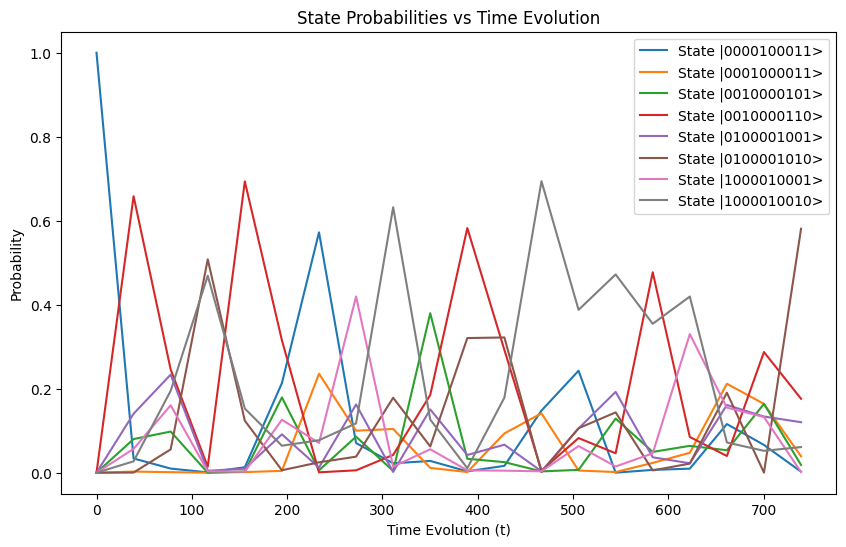

['0100001010', '1000010010', '0010000110', '0010000101', '0000100011', '1000010001', '0001000011']


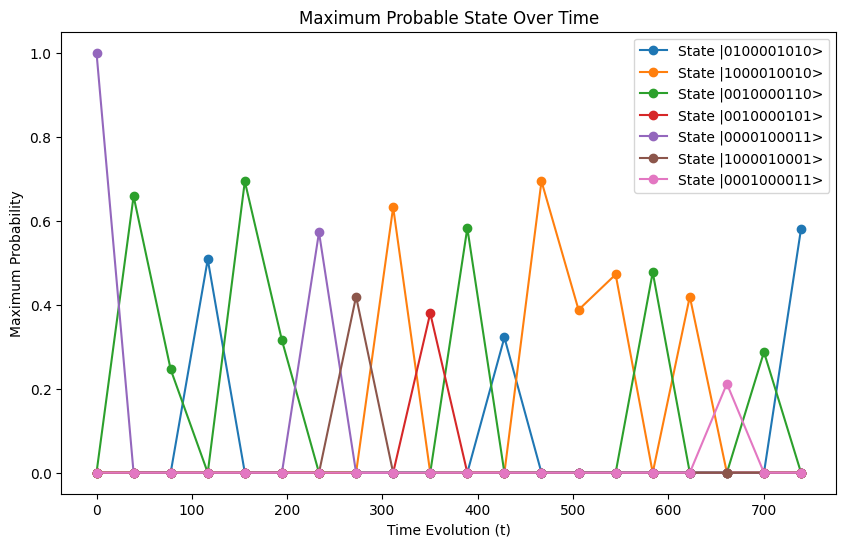

In [121]:
# Step 5: Plotting all state probabilities over time
all_states = set()
for probs in state_probabilities.values():
    all_states.update(probs.keys())


all_states = sorted(all_states)
fig, ax = plt.subplots(figsize=(10, 6))
for state in all_states:
    probs_over_time = [state_probabilities[t].get(state, 0.0) for t in evolution_times]
    ax.plot(evolution_times, probs_over_time, label=f"State |{state}>")

ax.set_title("State Probabilities vs Time Evolution")
ax.set_xlabel("Time Evolution (t)")
ax.set_ylabel("Probability")
ax.legend()
plt.grid(False)
plt.show()

# Step 6: Plot the maximum probable state over time
times, states, max_probs = zip(*max_probable_states)
unique_states = list(set(states))  # List of all unique max probable states
print(unique_states)
fig, ax = plt.subplots(figsize=(10, 6))
for state in unique_states:
    state_probs = [
        max_probs[i] if states[i] == state else 0.0 for i in range(len(times))
    ]
    ax.plot(times, state_probs, marker='o', label=f"State |{state}>")

ax.set_title("Maximum Probable State Over Time")
ax.set_xlabel("Time Evolution (t)")
ax.set_ylabel("Maximum Probability")
ax.legend()
plt.grid(False)
plt.show()

In [130]:
# Sort the states based on max probability
sorted_states = sorted(max_probable_states, key=lambda x: x[2], reverse=True)

# Unpack sorted data
times, states, max_probs = zip(*sorted_states)

# Print sorted states and their probabilities
print("Sorted States by Probability:")
for time, state, prob in sorted_states:
    print(f"Time: {time}, State: {state}, Probability: {prob}")

# Sorted probabilities
print("Sorted Probabilities:", max_probs)

Sorted States by Probability:
Time: 0.0, State: 0000100011, Probability: 1.0
Time: 466.84829721362235, State: 1000010010, Probability: 0.69406
Time: 155.61609907120743, State: 0010000110, Probability: 0.69368
Time: 38.90402476780186, State: 0010000110, Probability: 0.65839
Time: 311.23219814241486, State: 1000010010, Probability: 0.63207
Time: 389.04024767801855, State: 0010000110, Probability: 0.58248
Time: 739.1764705882354, State: 0100001010, Probability: 0.58093
Time: 233.42414860681117, State: 0000100011, Probability: 0.5724
Time: 116.71207430340559, State: 0100001010, Probability: 0.50801
Time: 583.5603715170279, State: 0010000110, Probability: 0.47729
Time: 544.656346749226, State: 1000010010, Probability: 0.47206
Time: 272.328173374613, State: 1000010001, Probability: 0.41957
Time: 622.4643962848297, State: 1000010010, Probability: 0.41947
Time: 505.7523219814242, State: 1000010010, Probability: 0.38782
Time: 350.1362229102167, State: 0010000101, Probability: 0.37984
Time: 427.

In [51]:
sample_states = ['1000010010', '0010000110', '0000100011', '0100001010']
k = len(sample_states)
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i, state1 in enumerate(sample_states):
    for j, state2 in enumerate(sample_states):
        state2e = Statevector.from_label(state2).evolve(qubit_hamiltonian)
        # print(Statevector.from_label(state1).inner(state2e))
        E_sub[i, j] = Statevector.from_label(state1).inner(state2e)
        S_sub[i, j] = Statevector.from_label(state1).inner(Statevector.from_label(state2))
        # print(Statevector.from_label(state1).inner(Statevector.from_label(state2)))

In [52]:
E_sub

array([[-1.8816127 +0.j,  0.01686914+0.j, -0.00983237+0.j,
         0.01686914+0.j],
       [ 0.01686914+0.j, -1.8816127 +0.j, -0.00983237+0.j,
         0.01686914+0.j],
       [-0.00983237+0.j, -0.00983237+0.j, -7.31552598+0.j,
        -0.00983237+0.j],
       [ 0.01686914+0.j,  0.01686914+0.j, -0.00983237+0.j,
        -1.8816127 +0.j]])

In [53]:
S_sub

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [54]:
eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)

[-7.31557902 -1.89848184 -1.89848184 -1.84782137]
[[ 0.00179825+0.j  0.42450922+0.j  0.69746583+0.j -0.57734747+0.j]
 [ 0.00179825+0.j -0.81627774+0.j  0.01890286+0.j -0.57734747+0.j]
 [ 0.99999515+0.j  0.        +0.j  0.        +0.j  0.00311467+0.j]
 [ 0.00179825+0.j  0.39176852+0.j -0.71636869+0.j -0.57734747+0.j]]
